# pyplearnr demo
Here I demonstrate pyplearnr, a wrapper for model validation and selection using nested k-fold cross-validation.

## Titanic dataset example
Here I use the Titanic dataset I've cleaned and pickled in a separate tutorial.

### Import data

In [1]:
import pandas as pd

df = pd.read_pickle('trimmed_titanic_data.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null int64
Pclass      890 non-null int64
Sex         890 non-null object
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null object
Title       890 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


By "cleaned" I mean I've derived titles (e.g. "Mr.", "Mrs.", "Dr.", etc) from the passenger names, imputed the missing Age values using polynomial regression with grid-searched 10-fold cross-validation, filled in the 3 missing Embarked values with the mode, and removed all fields that could be considered an id for that individual.

Thus, there is no missing/null data.

## Set categorical features as type 'category'
In order to one-hot encode categorical data, its best to set the features that are considered categorical:

In [2]:
simulation_df = df.copy()

categorical_features = ['Survived','Pclass','Sex','Embarked','Title']

for feature in categorical_features:
    simulation_df[feature] = simulation_df[feature].astype('category')
    
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null category
Pclass      890 non-null category
Sex         890 non-null category
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null category
Title       890 non-null category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.3 KB


## One-hot encode categorical features

In [3]:
simulation_df = pd.get_dummies(simulation_df,drop_first=True)

simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
Age               890 non-null float64
SibSp             890 non-null int64
Parch             890 non-null int64
Fare              890 non-null float64
Survived_1        890 non-null uint8
Pclass_2          890 non-null uint8
Pclass_3          890 non-null uint8
Sex_male          890 non-null uint8
Embarked_Q        890 non-null uint8
Embarked_S        890 non-null uint8
Title_Dr          890 non-null uint8
Title_Military    890 non-null uint8
Title_Miss        890 non-null uint8
Title_Mr          890 non-null uint8
Title_Mrs         890 non-null uint8
Title_Noble       890 non-null uint8
Title_Rev         890 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB


Now we have 17 features.

### Split into input/output data

In [4]:
# Set output feature
output_feature = 'Survived_1'

# Get all column names
column_names = list(simulation_df.columns)

# Get input features
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

### Null model

In [5]:
simulation_df['Survived_1'].value_counts().values/float(simulation_df['Survived_1'].value_counts().values.sum())

array([ 0.61573034,  0.38426966])

Thus, null accuracy of ~62% if we always predict death.

### Import pyplearnr and initialize optimized pipeline collection

In [6]:
%matplotlib inline

import pyplearnr as ppl

### KNN with and without pre-processing and various options
#### Basic KNN
Here we do a K-nearest neighbors (KNN) classification with stratified and nested 3-by-3-fold cross-validation over the 1 to 30 nearest neighbors and the use of either "uniform" or "distance" weights:

In [7]:
%%time 

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=2369,
                                      outer_loop_split_seed=461,
                                      inner_loop_split_seeds=[284, 406, 303])

# Design combinatorial pipeline schematic
pipeline_schematic = [
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
    }}}
]

# Form scikit-learn pipelines using the PipelineBuilder
pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_schematic)

print 'Number of pipelines: %d'%(len(pipelines)), '\n'

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipelines, scoring_metric='auc', score_type='median')

Number of pipelines: 60 

Outer Fold: 2 

51 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='distance'))])
55 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=28, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with best_inner_fold_pipeline_inds keyword argument.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {0:9, 2:3})

CPU times: user 5.03 s, sys: 49.5 ms, total: 5.07 s
Wall time: 5.16 s


Pyplearnr has indicated that the contest of outer-fold 2 has resulted in a tie between two pipelines with the same median score over all inner-folds. We can resolve this by re-running the fit method with the best_inner_fold_pipeline_inds keyword argument. I'll choose the simplest (higher number of neighbors):

In [8]:
kfcv.fit(X.values, y.values, pipelines, 
         best_inner_fold_pipeline_inds = {2:55})

55 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=28, p=2,
           weights='distance'))])
21 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='distance'))])
31 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with one of the indices above.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=9)


Whatever pipline wins the most outer-fold contests wins overall.

In this case, pyplearnr has notified us that all inner-fold contests of each outer-fold have resulted in different winners. We can resolve this conflict by, again, re-running the fit method, but with the best_outer_fold_pipeline keyword argument:

In [9]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=55)


--------------------------------------------------------------------------------
Best pipeline: 55
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.6582            min    0.6749     0.669    0.6558
 25%    0.6621            25%    0.6752    0.6956     0.673
 50%    0.6659            50%    0.6755    0.7222    0.6903
 75%    0.6903            75%    0.6911    0.7296    0.7149
 max    0.7146            max    0.7066    0.7371    0.7395
----------------------  ------------------------------------
mean    0.6796           mean    0.6857    0.7094    0.6952
 std   0.03059            std   0.01818   0.03576   0.04207
----------------------  ------------------------------------
 OF0    0.7146            IF0    0.6755    0.7222    

The output report lists the winning pipeline index, its validation (outer-fold test) scores and statistics, inner-fold (IF) test scores and statistics for each outer-fold (OF), a layout of the pipeline steps, and parameters.

Additionally, the report contains the outer- and inner-loop fold counts, seeds, scoring metric, and scoring type. These, along with the same data and pipelines, can be used as inputs to the nested k-fold cross-validation object initialization and its fit method to uniquely duplicate the results of this run.

We can get a visual report of this pipeline's validation scores and the inner-loop test scores for each outer-fold:

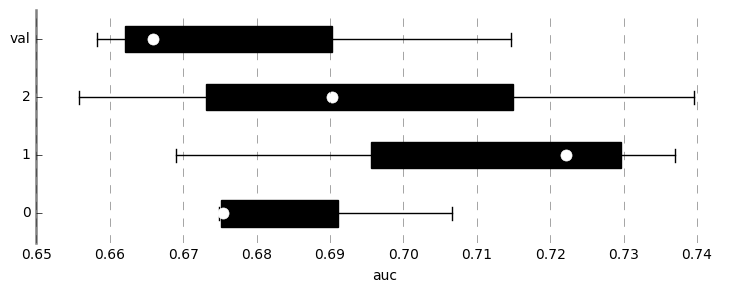

In [10]:
kfcv.plot_best_pipeline_scores()

Additionally we can visualize the performance of all pipelines over all folds:

In [16]:
%load_ext autoreload

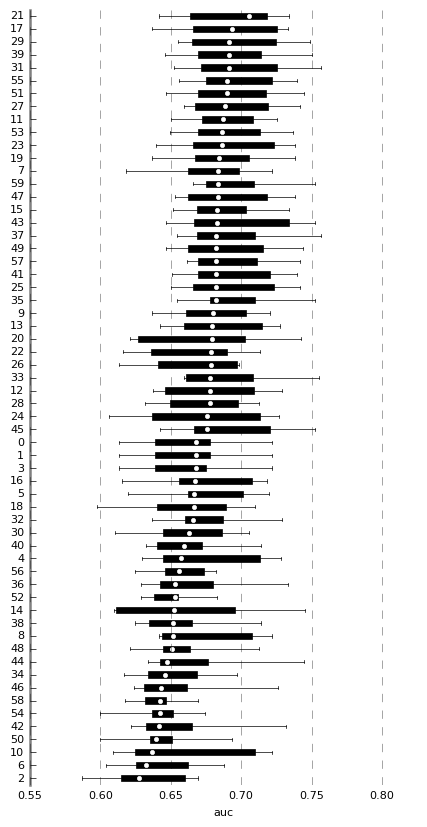

In [18]:
%autoreload

kfcv.plot_contest(all_folds=True, markersize=3, figsize=(5,10), fontsize=8) #, highlight_best=True

Additionally, we can visualize the test fold scores in all folds separately:

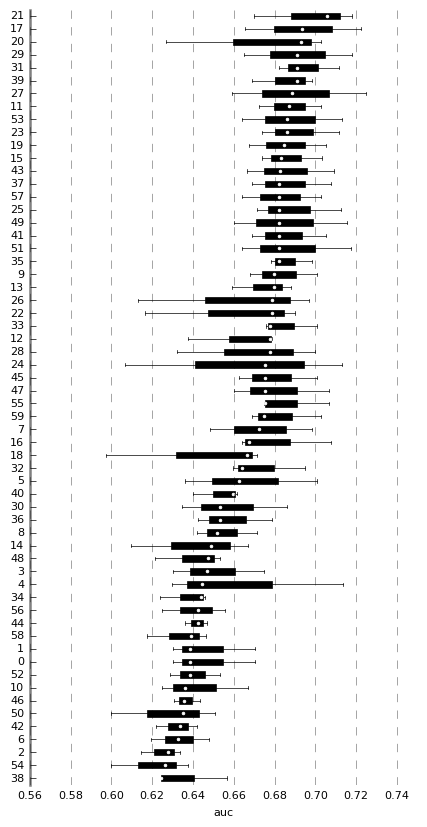

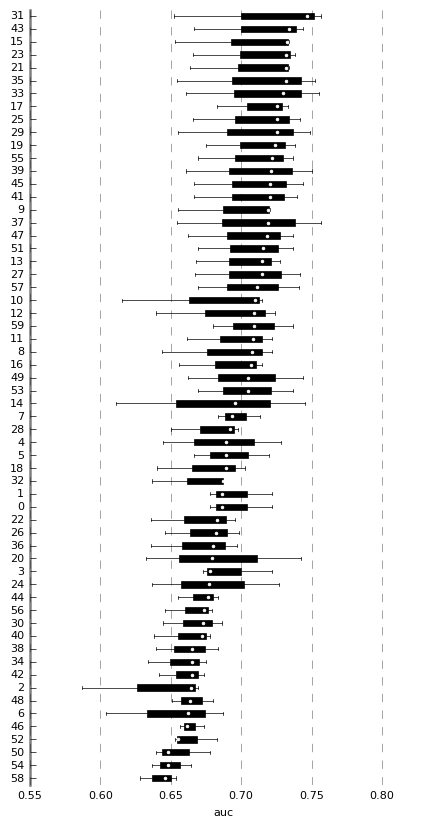

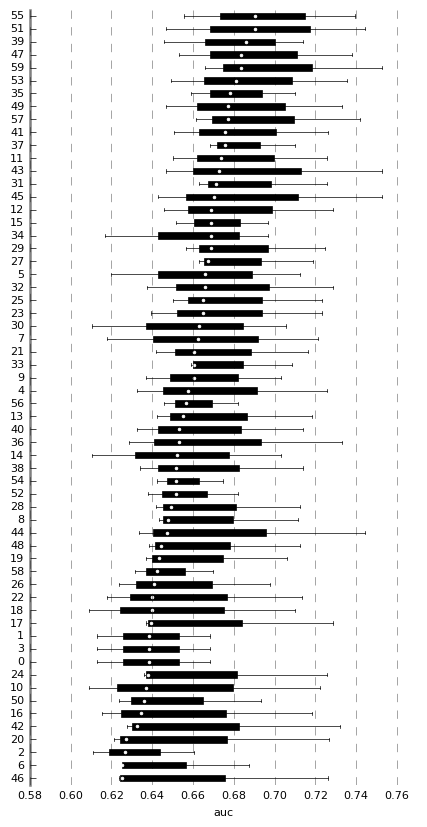

In [14]:
kfcv.plot_contest(markersize=2, figsize=(5,10), fontsize=8)

The validation score range is within the

This pipeline's performance was better in fold 0, though similar to that in folds 1 and 2.

We can also look at the fine details of the inner-fold contests of each outer-fold in order:

In [ ]:
kfcv.plot_contest()

The combined scores for all inner-loop contests for each pipeline can also be plotted:

In [ ]:
kfcv.plot_contest(all_folds=True)

# Different estimators

In [ ]:
%%time 

import numpy as np

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3)

# Design combinatorial pipeline schematic
pipeline_schematic = [
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
                },
            'svm': {
                'C': logspace() 
            }
        }
    }
]

# Form scikit-learn pipelines using the PipelineBuilder
pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_schematic)

print 'Number of pipelines: %d'%(len(pipelines)), '\n'

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipelines, scoring_metric='auc')

Pyplearnr has indicated that there is a tie in between one of the 60 pipelines in the inner-loop contest of outer-folds 0. We can specify the winner (preferably the simplest) by re-running the fit method but with the best_inner_fold_pipeline_inds keyword argument. 

Here I choose pipeline 39 for outer-fold 0 (higher number of neighbors is simpler for KNN):

In [ ]:
kfcv.fit(X.values, y.values, pipelines, 
    best_inner_fold_pipeline_inds = {2:1})

Pyplearnr has now found a tie in the final outer-loop contest. Between pipelines 3, 4, and 39. Here I use the best_outer_fold_pipeline with the fit method to resolve this conflict:

In [ ]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=59)

The output report lists the winning pipeline index, its validation (outer-loop test) scores and statistics, inner-loop test scores and statistics for each outer loop, a layout of the pipeline steps, and parameters that uniquely define this particular run of the procedure. 

Pyplearnr has chosen the best pipeline as that containing a k-nearest neighbors classifier with k=11.

The outer- and inner-loop fold counts, seeds, scoring metric, and scoring types, along with the same data and pipelines, can be used to uniquely duplicate the results of this run:

In [ ]:
%%time 

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=2949,
                                      outer_loop_split_seed=70,
                                      inner_loop_split_seeds=[527, 68, 472])

# Design combinatorial pipeline schematic
pipeline_schematic = [
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
    }}}
]

# Form scikit-learn pipelines using the PipelineBuilder
pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_schematic)

print 'Number of pipelines: %d'%(len(pipelines)), '\n'

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipelines, scoring_metric='auc')

In [ ]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=17)

Two visual reports are available: 1) plot_best_pipeline_scores and 2) plot_contest.

The plot_best_pipeline_scores method plots the winning pipeline in a box-and-whisker plot 

In [ ]:
%matplotlib inline

kfcv.plot_best_pipeline_scores(number_size=18, markersize=14)

Note how the estimator\_\_weights parameter isn't set for the KNN estimator.

### KNN with scaling
The currently supported scaling options are standard, normal, min-max, and binary using scikit-learn's StandardScaler, Normalizer, MinMaxScaler, and Binarizer, respectively. These are set by the pipeline initialization kwarg 'scale_type' like this:

In [ ]:
%%time

estimator = 'knn'

scaling_options = ['standard','normal','min-max','binary']

for scaling_option in scaling_options:
    model_name = '%s_%s'%(scaling_option,estimator_name)
    
    optimized_pipeline_kwargs = {
        'scale_type': scaling_option
    }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'use_default_param_dist': True,
        'suppress_output': True
        
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    optimized_pipelines[model_name] = optimized_pipeline

Let's compare the pipelines so far:

In [ ]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Binary scaling fed into a KNN classifier appears to have the best training score.

#### KNN with custom min-max and binary scaling settings
MinMaxScaler scales each feature value to between 0 and 1 by default. Different scaling ranges can be gridded over by setting the 'scaler\_\_feature_range' keyword argument in param_dist.

Binarizer sets each value to 0 or 1 depending on a threshold. The default for pyplearnr is 0.5. This can be changed by setting 'scaler\_\_threshold' using param_dist.

Here is an example of setting both:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

scaling_options = ['min_max','binary']

param_dists = {
    'min_max': {
        'scaler__feature_range': [(1,2),(3,4)]
    },
    'binary': {
        'scaler__threshold': np.arange(0,1,0.1)
    }
}

for scaling_option in scaling_options:
    model_name = 'custom_%s_%s'%(scaling_option,estimator_name)
    
    optimized_pipeline_kwargs = {
        'scale_type': scaling_option
    }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'use_default_param_dist': True,
        'suppress_output': True,
        'param_dist': param_dists[scaling_option]
        
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Switching the range for min_max scaling boosted it to rank 1 for pipeline training scores:

In [ ]:
print optimized_pipelines['custom_min_max_knn']

The range of 1 to 2 for the MinMaxScaler appeared to be the best.

### KNN with feature selection using SelectKBest with f_classif
Currently only one form of feature selection, SelectKBest with f_classif, is supported. This is set using the 'feature_selection_type' keyword argument.

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'select_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_selection_type': 'select_k_best'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Feature selection and KNN did had a mid-level training score:

In [ ]:
print optimized_pipelines['select_knn']

SelectKBest with f_classif chose 5 features as the best to use in the model.

The features selected by SelectKBest can be accessed normally, using the mask obtained from the get_support() method on the columns:

In [ ]:
feature_selection_mask = optimized_pipelines['select_knn'].pipeline.named_steps['feature_selection'].get_support()

print np.array(X.columns)[feature_selection_mask]

Thus, Pclass 3, being male, and the titles Miss, Mr, and Mrs were considered the most important features by SelectKBest using f_classif.

#### Setting custom feature selection
The default number of features is 1 to all of them. This can be gridded over different values by setting 'feature_selection\_\_k' in param_dist:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'custom_select_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_selection_type': 'select_k_best'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

param_dist = {
    'feature_selection__k': [5,7,8]
}

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'param_dist': param_dist
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['custom_select_knn']

### KNN using feature interactions
Feature products of different degrees can be used as additional features by setting the 'feature_interaction' OptimizedPipeline keyword argument to True:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'interaction_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_interactions': True
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['interaction_knn']

The optimal number of interactions (number of features multiplied by each other at once) was found to be 1.

#### KNN using custom number of feature interactions
The 'feature_interactions__degree' dictates the number of interactions. The default setting is to try no interactions (degree 1) and 2 interactions. Setting this in param_dist allows custom numbers:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'custom_interaction_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_interactions': True
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

param_dist = {
    'feature_interactions__degree': [2,3,4]
}

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'param_dist': param_dist
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['custom_interaction_knn']

### KNN with pre-processing transforms
Currently Principal Component Analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE) are supported as pre-processing options.

#### KNN with PCA pre-processing

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'pca_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'transform_type': 'pca'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['pca_knn']

We can look at the transformed data after PCA normally:

In [ ]:
transformed_data = optimized_pipelines['pca_knn'].pipeline.named_steps['transform'].transform(X.values)

column_names = ['PCA_%d'%(feature_ind+1) for feature_ind in range(transformed_data.shape[1])]

pca_df = pd.DataFrame(transformed_data,columns=column_names)

pca_df.plot(x='PCA_1',y='PCA_2',style='ro')

This is currently a very manual process and would be difficult with more and more processing steps. I'm thinking of automating this with a class containing all optimized pipelines in the future.

Any of the parameters displayed in the pipeline section of the report (iterated_power, random_state, whiten, n_components, etc) can be set in param_dist by 'transform\__setting' as done previously.

#### KNN with t-SNE pre-processing
The t-SNE algorithm can be used as a pre-processing algorithm as well by setting the 'transform_type' keyword argument to 't-sne':

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 't-sne_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'transform_type': 't-sne'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

This t-SNE step takes longer than most in pyplearnr unfortunately. It also resulted in the worst score. I'll try to optimize this in the future.

### Reducing the number of grid combinations
Setting the 'num_parameter_combos' fit() method keyword argument to an integer will limit the number of grid combinations to perform using RandomizedSearchCV instead of GridSearchCV:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'less_combos_%s'%(estimator_name)

optimized_pipeline_kwargs = {}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'num_parameter_combos': 5
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

This is a good way to speed up computations and give you an idea as to how long a particular pipeline takes to train. 

Here's the corresponding report:

In [ ]:
print optimized_pipelines['less_combos_knn']

The best parameter combination, of those attempted by RandomizedSearchCV, was 12 nearest neighbors with the 'uniform' weight.

### Other models

This code currently supports K-nearest neighbors, logistic regression, support vector machines, multilayer perceptrons, random forest, and adaboost:

In [ ]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {}

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Save 
    optimized_pipelines[estimator] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Logistic regression, random forest, multilayer perceptron, and adaboost outperform KNN, even with all of the attempted pre-processing so far.

### Putting it all together
Different combinations of these options can be strung together simultaneously to iterate over multiple models:

In [ ]:
%%time

import itertools

estimators = ['knn','logistic_regression','svm',
              'multilayer_perceptron','random_forest','adaboost']

feature_interaction_options = [True,False]
feature_selection_options = [None,'select_k_best']
scaling_options = [None,'standard','normal','min_max','binary']
transformations = [None,'pca']

pipeline_steps = [feature_interaction_options,feature_selection_options,scaling_options,
                  transformations,estimators]

pipeline_options = list(itertools.product(*pipeline_steps))

optimized_pipelines = {}

for pipeline_step_combo in pipeline_options:
    model_name = []
    
    feature_interactions = pipeline_step_combo[0]
    
    if feature_interactions:
        model_name.append('interactions')
        
    feature_selection_type = pipeline_step_combo[1]
    
    if feature_selection_type:
        model_name.append('select')
    
    scale_type = pipeline_step_combo[2]
    
    if scale_type:
        model_name.append(scale_type)
        
    transform_type = pipeline_step_combo[3]
    
    if transform_type:
        model_name.append(transform_type)
        
    estimator = pipeline_step_combo[4]
    
    model_name.append(estimator)
    
    model_name = '_'.join(model_name)
    
    print model_name
    
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': feature_selection_type,
        'scale_type': scale_type,
        'feature_interactions': feature_interactions,
        'transform_type': transform_type
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': None,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2 # 20% saved as test set
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save optimized pipeline
    optimized_pipelines[model_name] = optimized_pipeline

In [ ]:
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black',figsize=(10,40))

In [ ]:
print optimized_pipelines['min_max_pca_multilayer_perceptron']

In [ ]:
len(optimized_pipelines.keys())

Out of 240 different possible pipelines, best pipeline, with a test score of 0.899, appears to be min-max scaling between 0 and 1 funneled into a PCA and then into a multilayer perceptron with one hidden layer of size 5.

It took roughly 3 hours to find it.

### Predicting survival with the optimal model
All one has to do to make a prediction is use the .predict method of the pipeline in the .pipeline field.

Here's an example of predicting whether I would survive on the Titanic. I'm 32, would probably have one family member with me, might be Pclass1 (I'd hope), male, have a Ph.D (if that's what they mean by Dr.). I'm using the median Fare for Pclass 1 and randomly chose a city to have embarked from:

In [ ]:
personal_stats = [32,1,0,df[df['Pclass']==1]['Fare'].median(),0,0,1,1,0,1,0,0,0,0,0,0]

zip(personal_stats,X.columns)

In [ ]:
optimized_pipelines['min_max_pca_multilayer_perceptron'].pipeline.predict(personal_stats)

Looks like I died!

Let's look at my predicted probability of surviving:

In [ ]:
optimized_pipelines['min_max_pca_multilayer_perceptron'].pipeline.predict_proba(personal_stats)

I would have a 0.77% chance of survival.

## Summary
I've shown how to use pyplearnr to try out 240 different pipeline combinations validated with stratified 10-folds cross-validation using a combination of simple keyword arguments with some additional customization options. Also, I've shown how to access the model parameters, predict survival, and check the actual predicted probability according to the optimized pipeline.

Please let me know if you have any questions or suggestions about how to improve this tool, my code, the approach I'm taking, etc.